# biosc - diagnostics: isochrones and $A(Li)$ model comparison

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path
import pymc as pm
import arviz as az
import bambi as bmb
import xarray as xr
import biosc
import biosc.preprocessing
import matplotlib.ticker as ticker

from pymc import HalfCauchy, Model, Normal, sample

import os
import matplotlib.cm as cm
from netCDF4 import Dataset as NetCDFFile
from scipy.stats import gaussian_kde

from biosc.preprocessing import Preprocessing
from biosc.bhm import BayesianModel

import sys
sys.path.append('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/')

import bmp
from bmp import BayesianModelPlots

In [2]:
plt.rcParams.update({'font.size': 14, 'axes.linewidth': 1, 'axes.edgecolor': 'k'})
plt.rcParams['font.family'] = 'serif'

data_file = 'test_ALi_low_clean_only_good.csv'
file = 'output_test_UCDs_low_clean_only_good_uninf.nc'
path_data = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/test_ALi_low_clean_only_good.csv'
path_models = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/BT-Settl_all_Myr_Gaia+2MASS+PanSTARRS.csv'
L = 10
priors = {
    'Age [Myr]': {'dist': 'uniform', 'lower': 60, 'upper': 150},
    'Distance [pc]': {'dist': 'normal', 'mu': 135, 'sigma': 20}
}
ages = [0.02, 0.08, 0.12, 0.5]
colormap = 'turbo'
plot_type = 'all'

bayesian_plots = BayesianModelPlots(data_file, priors, file, path_data, path_models, L, ages, colormap)
bayesian_plots.process_idata(plot_type=plot_type)

### Pleiades data

In [3]:
data_obs_Pleiades = pd.read_csv('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/Pleiades_DANCe+GDR3+2MASS+PanSTARRS1+A_Li.csv')

data_obs_Pleiades.rename(columns={'g_error': 'e_g', 'rp_error': 'e_rp', 'bp_error': 'e_bp'}, inplace=True)
data_obs_Pleiades.columns

Index(['source_id', 'Mecayotl', 'Olivares+2018', 'Meingast+2021', 'l', 'b',
       'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error',
       'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'pmra_pmdec_corr',
       'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr',
       'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'g', 'bp', 'rp', 'e_g',
       'e_bp', 'e_rp', 'dr3_radial_velocity', 'dr3_radial_velocity_error',
       'ruwe', 'astrometric_excess_noise', 'astrometric_params_solved',
       'bp_rp', 'g_rp', 'Jmag', 'Hmag', 'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag',
       'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag',
       'ymag', 'e_ymag', 'Name', 'EPIC', 'RAJ2000', 'DEJ2000', 'Vmag', 'J-K',
       'Per', 'Amp', 'l_WLi', 'WLi', 'e_WLi', 'Teff', 'ALi', 'e_ALi', 'Bin',
       'SimbadName'],
      dtype='object')

In [4]:
distance_obs = 1 / (data_obs_Pleiades['parallax'] * 1e-3)
distance_mod_obs = 5 * np.log10(distance_obs) - 5  
data_obs_Pleiades['g_abs'] = data_obs_Pleiades['g'] - distance_mod_obs
data_obs_Pleiades['bp_abs'] = data_obs_Pleiades['bp'] - distance_mod_obs
data_obs_Pleiades['rp_abs'] = data_obs_Pleiades['rp'] - distance_mod_obs
data_obs_Pleiades['Jmag_abs'] = data_obs_Pleiades['Jmag'] - distance_mod_obs
data_obs_Pleiades['Hmag_abs'] = data_obs_Pleiades['Hmag'] - distance_mod_obs
data_obs_Pleiades['Kmag_abs'] = data_obs_Pleiades['Kmag'] - distance_mod_obs
data_obs_Pleiades['rmag_abs'] = data_obs_Pleiades['rmag'] - distance_mod_obs
data_obs_Pleiades['imag_abs'] = data_obs_Pleiades['imag'] - distance_mod_obs
data_obs_Pleiades['ymag_abs'] = data_obs_Pleiades['ymag'] - distance_mod_obs
data_obs_Pleiades['zmag_abs'] = data_obs_Pleiades['zmag'] - distance_mod_obs

### PARSEC

In [5]:
PARSEC_iso_omega_00 = np.loadtxt('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/PARSEC_iso_omega_06.dat')


In [6]:
len(PARSEC_iso_omega_00)

8284

In [7]:
with open('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/PARSEC_iso_omega_06.dat', 'r') as file:
    for i, line in enumerate(file):
        if i == 14:
            columns = line.strip().lstrip('#').split()
            break

In [8]:
PARSEC_iso_omega_00_dataframe = pd.DataFrame(PARSEC_iso_omega_00, columns=columns)


In [9]:
PARSEC_iso_omega_00_dataframe

Zini       MH  logAge      Mini   int_IMF   Mass   logL   logTe  \
0     0.001547 -0.58336    6.00  0.090000  1.081690  0.090 -1.161  3.4888   
1     0.001547 -0.58336    6.00  0.100000  1.171106  0.100 -1.062  3.4952   
2     0.001547 -0.58336    6.00  0.118399  1.308671  0.118 -0.909  3.5052   
3     0.001547 -0.58336    6.00  0.120000  1.319315  0.120 -0.897  3.5060   
4     0.001547 -0.58336    6.00  0.139167  1.433940  0.139 -0.765  3.5151   
...        ...      ...     ...       ...       ...    ...    ...     ...   
8279  0.001547 -0.58336    9.99  0.934984  2.458210  0.838  3.395  3.5441   
8280  0.001547 -0.58336    9.99  0.934984  2.458210  0.838  3.406  3.5426   
8281  0.001547 -0.58336    9.99  0.934985  2.458210  0.837  3.418  3.5411   
8282  0.001547 -0.58336    9.99  0.934985  2.458210  0.836  3.432  3.5393   
8283  0.001547 -0.58336    9.99  0.934986  2.458210  0.835  3.447  3.5375   

       logg  label  ...  K_i45  K_i50  K_i55  K_i60  K_i65  K_i70  K_i75  \
0     3.461    0.0  ...  4.939  4.939  4.939  4.939  4.939  4.939  4.939   
1     3.433    0.0  ...  4.705  4.705  4.705  4.705  4.705  4.705  4.705   
2     3.393    0.0  ...  4.343  4.343  4.343  4.343  4.343  4.343  4.343   
3     3.390    0.0  ...  4.314  4.314  4.314  4.314  4.314  4.314  4.314   
4     3.359    0.0  ...  4.001  4.001  4.001  4.001  4.001  4.001  4.001   
...     ...    ...  ...    ...    ...    ...    ...    ...    ...    ...   
8279  0.095    7.0  ... -6.592 -6.592 -6.592 -6.592 -6.592 -6.592 -6.592   
8280  0.077    7.0  ... -6.630 -6.630 -6.630 -6.630 -6.630 -6.630 -6.630   
8281  0.059    7.0  ... -6.667 -6.667 -6.667 -6.667 -6.667 -6.667 -6.667   
8282  0.038    7.0  ... -6.712 -6.712 -6.712 -6.712 -6.712 -6.712 -6.712   
8283  0.015    7.0  ... -6.760 -6.760 -6.760 -6.760 -6.760 -6.760 -6.760   

      K_i80  K_i85  K_i90  
0     4.939  4.939  4.939  
1     4.705  4.705  4.705  
2     4.343  4.343  4.343  
3     4.314  4.314  4.314  
4     4.001  4.001  4.001  
...     ...    ...    ...  
8279 -6.592 -6.592 -6.592  
8280 -6.630 -6.630 -6.630  
8281 -6.667 -6.667 -6.667  
8282 -6.712 -6.712 -6.712  
8283 -6.760 -6.760 -6.760  

[8284 rows x 219 columns]

In [10]:
PARSEC_iso_omega_00_dataframe.rename(columns={'Mass': 'M/Ms'}, inplace=True)

In [11]:
PARSEC_iso_omega_00_dataframe.columns[0:50]

Index(['Zini', 'MH', 'logAge', 'Mini', 'int_IMF', 'M/Ms', 'logL', 'logTe',
       'logg', 'label', 'McoreTP', 'C_O', 'period0', 'period1', 'period2',
       'period3', 'period4', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc', 'Xn',
       'Xo', 'Cexcess', 'Z', 'Teff0', 'omega', 'angvel', 'vtaneq', 'angmom',
       'Rpol', 'Req', 'mbolmag', 'U_fSBmag', 'B_fSBmag', 'V_fSBmag',
       'R_fSBmag', 'I_fSBmag', 'J_fSBmag', 'H_fSBmag', 'K_fSBmag', 'U_fSB',
       'U_f0', 'U_fk', 'U_i00', 'U_i05', 'U_i10', 'U_i15'],
      dtype='object')

In [12]:
PARSEC_iso_omega_00_dataframe['M/Ms']

0       0.090
1       0.100
2       0.118
3       0.120
4       0.139
        ...  
8279    0.838
8280    0.838
8281    0.837
8282    0.836
8283    0.835
Name: M/Ms, Length: 8284, dtype: float64

In [13]:
PARSEC_iso_omega_00_dataframe['Age [Gyr]'] = (10**(PARSEC_iso_omega_00_dataframe['logAge']))/(1e9)

In [14]:
PARSEC_iso_omega_00_dataframe.to_csv('PARSEC_iso_omega_06.csv', index=False)


In [15]:
lib = ['Gaia', '2MASS', 'PanSTARRS']

PARSEC_iso_omega_00_Phot = {}

for l in lib:
    data = np.loadtxt('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/PARSEC_iso_omega_00_'+l+'.dat')
    
    # Leer la fila 15 para obtener los nombres de las columnas
    with open('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/PARSEC_iso_omega_00_'+l+'.dat', 'r') as file:
        for i, line in enumerate(file):
            if i == 14:
                columns = line.strip().lstrip('#').split()
                break
    
    # Crear un DataFrame con los datos y los nombres de las columnas
    dataframe = pd.DataFrame(data, columns=columns)
    
    dataframe.rename(columns={'Mass': 'M/Ms'}, inplace=True)
    
    # Guardar el DataFrame en el diccionario con el nombre correspondiente
    PARSEC_iso_omega_00_Phot[l] = dataframe
    
    PARSEC_iso_omega_00_Phot[l]['Age [Gyr]'] = (10**(PARSEC_iso_omega_00_Phot[l]['logAge']))/(1e9)
    
common_columns = PARSEC_iso_omega_00_Phot['Gaia'].columns[:35]

dataframes_concatenate = [df for df in PARSEC_iso_omega_00_Phot.values()]

dataframe_final = pd.concat(dataframes_concatenate, axis=1)

dataframe_final = dataframe_final.loc[:,~dataframe_final.columns.duplicated()]

dataframe_final.to_csv('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/PARSEC_iso_omega_00_Phot.csv', index=False)

PARSEC_iso_omega_00_Phot_dict = {}

for age in dataframe_final['Age [Gyr]'].unique():
    dataframe_by_age = dataframe_final[dataframe_final['Age [Gyr]'] == age]
    dataframe_by_age = dataframe_by_age.loc[dataframe_by_age['G_i00'] > 0].reset_index(drop=True)
    PARSEC_iso_omega_00_Phot_dict[age] = dataframe_by_age


In [16]:
dataframe_final['Age [Gyr]']

0        0.002000
1        0.002000
2        0.002000
3        0.002000
4        0.002000
           ...   
41620    0.596994
41621    0.596994
41622    0.596994
41623    0.596994
41624    0.596994
Name: Age [Gyr], Length: 41625, dtype: float64

In [17]:
PARSEC_iso_omega_00_Phot['Gaia'].columns

Index(['Zini', 'MH', 'logAge', 'Mini', 'int_IMF', 'M/Ms', 'logL', 'logTe',
       'logg', 'label',
       ...
       'G_RP_i50', 'G_RP_i55', 'G_RP_i60', 'G_RP_i65', 'G_RP_i70', 'G_RP_i75',
       'G_RP_i80', 'G_RP_i85', 'G_RP_i90', 'Age [Gyr]'],
      dtype='object', length=105)

In [18]:
PARSEC_iso_omega_00_Phot_dict = {round(key, 3): value for key, value in PARSEC_iso_omega_00_Phot_dict.items()}


In [19]:
PARSEC_iso_omega_00_Phot_dict.keys()

dict_keys([0.002, 0.007, 0.012, 0.017, 0.022, 0.027, 0.032, 0.037, 0.042, 0.047, 0.052, 0.057, 0.062, 0.067, 0.072, 0.077, 0.082, 0.087, 0.092, 0.097, 0.102, 0.107, 0.112, 0.117, 0.122, 0.127, 0.132, 0.137, 0.142, 0.147, 0.152, 0.157, 0.162, 0.167, 0.172, 0.177, 0.182, 0.187, 0.192, 0.197, 0.202, 0.207, 0.212, 0.217, 0.222, 0.227, 0.232, 0.237, 0.242, 0.247, 0.252, 0.257, 0.262, 0.267, 0.272, 0.277, 0.282, 0.287, 0.292, 0.297, 0.302, 0.307, 0.312, 0.317, 0.322, 0.327, 0.332, 0.337, 0.342, 0.347, 0.352, 0.357, 0.362, 0.367, 0.372, 0.377, 0.382, 0.387, 0.392, 0.397, 0.402, 0.407, 0.412, 0.417, 0.422, 0.427, 0.432, 0.437, 0.442, 0.447, 0.452, 0.457, 0.462, 0.467, 0.472, 0.477, 0.482, 0.487, 0.492, 0.497, 0.502, 0.507, 0.512, 0.517, 0.522, 0.527, 0.532, 0.537, 0.542, 0.547, 0.552, 0.557, 0.562, 0.567, 0.572, 0.577, 0.582, 0.587, 0.592, 0.597])

### BT-Settl

In [20]:
path_models = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/BT-Settl_all_Myr_Gaia+2MASS+PanSTARRS.csv'


In [21]:
BTSettl = pd.read_csv(path_models)
BTSettl

age_Myr  t(Gyr)   M/Ms  Teff(K)  L/Ls  lg(g)  R(Gcm)     D      Li  \
0        1.0   0.001  0.010   2345.0 -2.70   3.57   18.99  1.00  1.0000   
1        1.0   0.001  0.015   2504.0 -2.42   3.58   22.90  1.00  1.0000   
2        1.0   0.001  0.020   2598.0 -2.25   3.59   26.11  1.00  1.0000   
3        1.0   0.001  0.030   2710.0 -1.98   3.57   32.78  1.00  1.0000   
4        1.0   0.001  0.040   2779.0 -1.81   3.57   37.62  0.99  1.0000   
..       ...     ...    ...      ...   ...    ...     ...   ...     ...   
833  10000.0  10.000  0.500   3689.0 -1.43   4.78   33.05  0.00  0.0000   
834  10000.0  10.000  0.600   4013.0 -1.12   4.70   39.92  0.00  0.0000   
835  10000.0  10.000  0.700   4493.0 -0.79   4.63   46.43  0.00  0.0000   
836  10000.0  10.000  0.800   5002.0 -0.47   4.55   54.44  0.00  0.0000   
837  10000.0  10.000  0.900   5495.0 -0.12   4.42   67.60  0.00  0.0626   

          G       G_BP     G_RP      J      H      K    g_p1    r_p1    i_p1  \
0    14.055  17.784799  12.4668  9.328  8.770  8.353  17.937  17.095  13.757   
1    13.015  16.269800  11.4758  8.667  8.135  7.751  16.291  15.787  12.540   
2    12.381  15.366800  10.8708  8.238  7.710  7.347  15.366  14.935  11.827   
3    11.507  14.182800  10.0358  7.582  7.054  6.720  14.194  13.747  10.885   
4    10.990  13.496800   9.5408  7.188  6.652  6.338  13.512  13.061  10.339   
..      ...        ...      ...    ...    ...    ...     ...     ...     ...   
833   8.937   9.932800   7.9128  6.589  5.944  5.721  10.162   9.297   8.342   
834   7.960   8.747800   7.0678  5.926  5.237  5.059   9.010   8.100   7.463   
835   6.900   7.487800   6.1598  5.244  4.614  4.490   7.754   6.870   6.537   
836   5.925   6.365800   5.3108  4.580  4.098  4.000   6.529   5.885   5.675   
837   4.972   5.317800   4.4508  3.860  3.490  3.410   5.422   4.944   4.804   

       y_p1    z_p1  
0    12.125  11.009  
1    11.155  10.214  
2    10.566   9.722  
3     9.754   9.006  
4     9.275   8.580  
..      ...     ...  
833   7.936   7.713  
834   7.188   7.015  
835   6.392   6.271  
836   5.594   5.525  
837   4.769   4.741  

[838 rows x 20 columns]

In [22]:
BTSettl.rename(columns={
    'age_Myr': 'age_Gyr',
    'Teff(K)': 'Teff',
    'G_RP': 'RP',
    'G_BP': 'BP',
    'r_p1': 'r',
    'i_p1': 'i',
    'y_p1': 'y',
    'z_p1': 'z'}, inplace=True)

BTSettl['age_Gyr'] *= 0.001
BTSettl['A(Li)'] = np.log10(BTSettl['Li']) + 3.3

# Create a dictionary to store dataframes for each isochrone
BTSettl_Li_isochrones = {}

# Loop over each row in the model dataframe
for index, row in BTSettl.iterrows():
    # Get the value of age_Gyr from the current row
    age_Gyr = row['age_Gyr']

    # Check if the value of age_Gyr already exists as a key in the dictionary
    if age_Gyr not in BTSettl_Li_isochrones:
        # If it doesn't exist, create a new entry in the dictionary with the value of age_Gyr as the key
        BTSettl_Li_isochrones[age_Gyr] = []

    # Add the current row to the corresponding value of age_Gyr in the dictionary
    BTSettl_Li_isochrones[age_Gyr].append(row)

# Convert each list of rows into a dataframe and replace the list in the dictionary
for age_Gyr, rows in BTSettl_Li_isochrones.items():
    BTSettl_Li_isochrones[age_Gyr] = pd.DataFrame(rows)



/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/biosc_env/lib64/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
BTSettl_Li_isochrones[0.08]

age_Gyr  t(Gyr)   M/Ms    Teff  L/Ls  lg(g)  R(Gcm)    D      Li  \
413     0.08    0.08  0.015  1372.0 -4.26   4.37    9.27  0.0  1.0000   
414     0.08    0.08  0.020  1489.0 -4.14   4.52    8.96  0.0  1.0000   
415     0.08    0.08  0.030  2047.0 -3.58   4.69    9.04  0.0  1.0000   
416     0.08    0.08  0.040  2387.0 -3.26   4.75    9.66  0.0  1.0000   
417     0.08    0.08  0.050  2586.0 -3.06   4.79   10.37  0.0  0.9990   
418     0.08    0.08  0.060  2709.0 -2.92   4.81   11.06  0.0  0.9850   
419     0.08    0.08  0.070  2829.0 -2.78   4.82   11.84  0.0  0.8640   
420     0.08    0.08  0.072  2845.0 -2.76   4.82   11.98  0.0  0.8010   
421     0.08    0.08  0.075  2869.0 -2.73   4.82   12.21  0.0  0.6800   
422     0.08    0.08  0.080  2905.0 -2.69   4.83   12.58  0.0  0.4070   
423     0.08    0.08  0.090  2962.0 -2.60   4.83   13.30  0.0  0.0197   
424     0.08    0.08  0.100  3010.0 -2.54   4.84   13.92  0.0  0.0000   
425     0.08    0.08  0.200  3275.0 -2.08   4.82   19.98  0.0  0.0000   
426     0.08    0.08  0.300  3406.0 -1.82   4.81   24.88  0.0  0.0000   
427     0.08    0.08  0.400  3522.0 -1.61   4.78   29.51  0.0  0.0000   
428     0.08    0.08  0.500  3668.0 -1.40   4.74   34.80  0.0  0.0000   
429     0.08    0.08  0.600  4039.0 -1.09   4.68   40.92  0.0  0.0000   
430     0.08    0.08  0.700  4497.0 -0.83   4.67   44.58  0.0  0.0000   
431     0.08    0.08  0.800  4830.0 -0.61   4.64   49.44  0.0  0.0048   
432     0.08    0.08  0.900  5212.0 -0.37   4.58   56.04  0.0  0.0825   
433     0.08    0.08  1.000  5533.0 -0.17   4.52   63.21  0.0  0.3070   
434     0.08    0.08  1.100  5876.0  0.05   4.46   71.48  0.0  0.5740   
435     0.08    0.08  1.200  6164.0  0.24   4.39   80.81  0.0  0.7700   
436     0.08    0.08  1.300  6451.0  0.41   4.33   90.02  0.0  0.8800   
437     0.08    0.08  1.400  6766.0  0.56   4.29   97.57  0.0  0.9380   

             G  ...         RP       J       H       K    g_p1       r  \
413  18.989000  ...  17.337799  13.908  12.584  11.858  24.678  21.378   
414  18.673999  ...  17.123801  13.846  12.482  11.568  23.584  20.346   
415  16.920000  ...  15.296800  11.571  10.822  10.415  21.883  19.166   
416  15.312000  ...  13.720800  10.695  10.116   9.778  19.737  17.984   
417  14.424000  ...  12.887800  10.248   9.681   9.358  18.124  16.974   
418  13.815000  ...  12.336800   9.942   9.366   9.055  16.715  16.015   
419  13.279000  ...  11.846800   9.654   9.083   8.780  15.923  15.103   
420  13.212000  ...  11.783800   9.610   9.038   8.738  15.831  15.005   
421  13.110000  ...  11.687800   9.541   8.969   8.673  15.693  14.858   
422  12.952000  ...  11.539800   9.434   8.862   8.571  15.478  14.632   
423  12.668000  ...  11.277800   9.245   8.672   8.390  15.053  14.236   
424  12.428000  ...  11.059800   9.090   8.515   8.240  14.676  13.886   
425  10.925000  ...   9.707800   8.052   7.453   7.201  12.531  11.779   
426  10.155000  ...   8.998800   7.457   6.845   6.602  11.618  10.825   
427   9.539000  ...   8.434800   6.984   6.359   6.122  10.897  10.076   
428   8.874000  ...   7.838800   6.496   5.849   5.624  10.115   9.261   
429   7.869000  ...   6.979800   5.851   5.159   4.985   8.928   7.993   
430   6.982000  ...   6.242800   5.329   4.701   4.577   7.835   6.952   
431   6.330000  ...   5.676800   4.889   4.360   4.255   7.008   6.288   
432   5.644000  ...   5.070800   4.404   3.973   3.884   6.176   5.608   
433   5.084000  ...   4.568800   3.988   3.624   3.546   5.526   5.057   
434   4.530000  ...   4.069800   3.570   3.272   3.203   4.893   4.513   
435   4.048000  ...   3.632800   3.194   2.942   2.877   4.352   4.041   
436   3.612000  ...   3.242800   2.858   2.648   2.588   3.863   3.616   
437   3.232000  ...   2.911800   2.581   2.413   2.357   3.427   3.248   

          i       y       z     A(Li)  
413  19.516  16.866  15.762  3.300000  
414  18.428  16.775  15.814  3.300000  
415  16.955  14.981  13.679  3.300000  
416  15.064  13.363  

### MIST

In [24]:
import sys
sys.path.append('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/')

In [25]:
import read_mist_models

In [26]:
iso_00_00_G2 = read_mist_models.ISOCMD('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd')


Reading in: /pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd


In [27]:
print('version: ', iso_00_00_G2.version)
print('abundances: ', iso_00_00_G2.abun)
print('rotation: ', iso_00_00_G2.rot)
print('ages: ', [round(x,2) for x in iso_00_00_G2.ages])
print('number of ages: ', iso_00_00_G2.num_ages)
print('available columns: ', iso_00_00_G2.hdr_list)

version:  {'MIST': '1.2', 'MESA': '7503'}
abundances:  {'Yinit': 0.2703, 'Zinit': 0.0142857, '[Fe/H]': 0.0, '[a/Fe]': 0.0}
rotation:  0.0
ages:  [5.0, 5.05, 5.1, 5.15, 5.2, 5.25, 5.3, 5.35, 5.4, 5.45, 5.5, 5.55, 5.6, 5.65, 5.7, 5.75, 5.8, 5.85, 5.9, 5.95, 6.0, 6.05, 6.1, 6.15, 6.2, 6.25, 6.3, 6.35, 6.4, 6.45, 6.5, 6.55, 6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05, 7.1, 7.15, 7.2, 7.25, 7.3, 7.35, 7.4, 7.45, 7.5, 7.55, 7.6, 7.65, 7.7, 7.75, 7.8, 7.85, 7.9, 7.95, 8.0, 8.05, 8.1, 8.15, 8.2, 8.25, 8.3, 8.35, 8.4, 8.45, 8.5, 8.55, 8.6, 8.65, 8.7, 8.75, 8.8, 8.85, 8.9, 8.95, 9.0, 9.05, 9.1, 9.15, 9.2, 9.25, 9.3, 9.35, 9.4, 9.45, 9.5, 9.55, 9.6, 9.65, 9.7, 9.75, 9.8, 9.85, 9.9, 9.95, 10.0, 10.05, 10.1, 10.15, 10.2, 10.25, 10.3]
number of ages:  107
available columns:  ['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', '

In [28]:
iso_00_00_P = read_mist_models.ISOCMD('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_PanSTARRS.iso.cmd')

Reading in: /pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_PanSTARRS.iso.cmd


In [29]:
print('version: ', iso_00_00_P.version)
print('abundances: ', iso_00_00_P.abun)
print('rotation: ', iso_00_00_P.rot)
print('ages: ', [round(x,2) for x in iso_00_00_P.ages])
print('number of ages: ', iso_00_00_P.num_ages)
print('available columns: ', iso_00_00_P.hdr_list)

version:  {'MIST': '1.2', 'MESA': '7503'}
abundances:  {'Yinit': 0.2703, 'Zinit': 0.0142857, '[Fe/H]': 0.0, '[a/Fe]': 0.0}
rotation:  0.0
ages:  [5.0, 5.05, 5.1, 5.15, 5.2, 5.25, 5.3, 5.35, 5.4, 5.45, 5.5, 5.55, 5.6, 5.65, 5.7, 5.75, 5.8, 5.85, 5.9, 5.95, 6.0, 6.05, 6.1, 6.15, 6.2, 6.25, 6.3, 6.35, 6.4, 6.45, 6.5, 6.55, 6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05, 7.1, 7.15, 7.2, 7.25, 7.3, 7.35, 7.4, 7.45, 7.5, 7.55, 7.6, 7.65, 7.7, 7.75, 7.8, 7.85, 7.9, 7.95, 8.0, 8.05, 8.1, 8.15, 8.2, 8.25, 8.3, 8.35, 8.4, 8.45, 8.5, 8.55, 8.6, 8.65, 8.7, 8.75, 8.8, 8.85, 8.9, 8.95, 9.0, 9.05, 9.1, 9.15, 9.2, 9.25, 9.3, 9.35, 9.4, 9.45, 9.5, 9.55, 9.6, 9.65, 9.7, 9.75, 9.8, 9.85, 9.9, 9.95, 10.0, 10.05, 10.1, 10.15, 10.2, 10.25, 10.3]
number of ages:  107
available columns:  ['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'PS_g', 'PS_r', 'PS_i', 'PS_z', 'PS_y', 'PS_w', 'PS_open', 'phase']


In [30]:
def isocmd_to_dataframe(isocmd_set, ages):
    data_dict = {}
    for age, isocmd in zip(ages, isocmd_set):
        data_dict[age] = pd.DataFrame(isocmd)
    return data_dict

filename_iso_P = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_PanSTARRS.iso.cmd'
filename_iso_G2 = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd'

iso_P = read_mist_models.ISOCMD(filename_iso_P)
iso_G2 = read_mist_models.ISOCMD(filename_iso_G2)

ages_P_sorted = sorted(iso_P.ages)
ages_G2_sorted = sorted(iso_G2.ages)

MIST_P = isocmd_to_dataframe(iso_P.isocmds, ages_P_sorted)
MIST_G2 = isocmd_to_dataframe(iso_G2.isocmds, ages_G2_sorted)

MIST_P = {round((10 ** age) / 1e9, 4): df for age, df in MIST_P.items()}
MIST_G2 = {round((10 ** age) / 1e9, 4): df for age, df in MIST_G2.items()}


Reading in: /pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_PanSTARRS.iso.cmd
Reading in: /pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd


In [31]:
MIST_P.keys()

dict_keys([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.0011, 0.0013, 0.0014, 0.0016, 0.0018, 0.002, 0.0022, 0.0025, 0.0028, 0.0032, 0.0035, 0.004, 0.0045, 0.005, 0.0056, 0.0063, 0.0071, 0.0079, 0.0089, 0.01, 0.0112, 0.0126, 0.0141, 0.0158, 0.0178, 0.02, 0.0224, 0.0251, 0.0282, 0.0316, 0.0355, 0.0398, 0.0447, 0.0501, 0.0562, 0.0631, 0.0708, 0.0794, 0.0891, 0.1, 0.1122, 0.1259, 0.1413, 0.1585, 0.1778, 0.1995, 0.2239, 0.2512, 0.2818, 0.3162, 0.3548, 0.3981, 0.4467, 0.5012, 0.5623, 0.631, 0.7079, 0.7943, 0.8913, 1.0, 1.122, 1.2589, 1.4125, 1.5849, 1.7783, 1.9953, 2.2387, 2.5119, 2.8184, 3.1623, 3.5481, 3.9811, 4.4668, 5.0119, 5.6234, 6.3096, 7.0795, 7.9433, 8.9125, 10.0, 11.2202, 12.5893, 14.1254, 15.8489, 17.7828, 19.9526])

In [32]:
MIST_P[0.0794]

EEP  log10_isochrone_age_yr  initial_mass  star_mass  log_Teff  \
0      144                     7.9      0.100000   0.100000  3.480012   
1      145                     7.9      0.103943   0.103943  3.481153   
2      146                     7.9      0.108153   0.108153  3.482125   
3      147                     7.9      0.112109   0.112109  3.482120   
4      148                     7.9      0.116157   0.116157  3.482430   
...    ...                     ...           ...        ...       ...   
1562  1706                     7.9      5.895973   0.960143  4.773429   
1563  1707                     7.9      5.897566   0.960308  4.765816   
1564  1708                     7.9      5.899257   0.960483  4.758217   
1565  1709                     7.9      5.901081   0.960671  4.750638   
1566  1710                     7.9      5.903031   0.960873  4.743077   

         log_g     log_L  [Fe/H]_init    [Fe/H]       PS_g       PS_r  \
0     4.807089 -2.494251          0.0  0.041367  14.537932  13.313097   
1     4.806544 -2.475255          0.0  0.041367  14.460232  13.237328   
2     4.805970 -2.455963          0.0  0.041368  14.386624  13.165249   
3     4.805524 -2.441607          0.0  0.041367  14.350819  13.129517   
4     4.804910 -2.425497          0.0  0.041366  14.302492  13.081729   
...        ...       ...          ...       ...        ...        ...   
1562  8.513988 -0.045370          0.0  0.111175   9.289133   9.768784   
1563  8.515703 -0.077464          0.0  0.111184   9.344283   9.823389   
1564  8.517411 -0.109489          0.0  0.111193   9.406273   9.884983   
1565  8.519113 -0.141423          0.0  0.111203   9.473080   9.951502   
1566  8.520813 -0.173273          0.0  0.111212   9.542765  10.020965   

           PS_i       PS_z       PS_y       PS_w    PS_open  phase  
0     11.557117  10.813014  10.385407  12.557887  11.790219   -1.0  
1     11.498117  10.759463  10.337256  12.494459  11.734118   -1.0  
2     11.440290  10.706257  10.288486  12.432819  11.678669   -1.0  
3     11.404458  10.670405  10.252594  12.397012  11.642826   -1.0  
4     11.361176  10.628593  10.212150  12.352513  11.600286   -1.0  
...         ...        ...        ...        ...        ...    ...  
1562  10.158804  10.446218  10.657974   9.688055   9.806467    4.0  
1563  10.213919  10.501945  10.713959   9.742990   9.861694    4.0  
1564  10.275879  10.564346  10.776545   9.804823   9.923737    4.0  
1565  10.342661  10.631447  10.843780   9.871513   9.990581    4.0  
1566  10.412323  10.701353  10.913789   9.941109  10.060292    4.0  

[1567 rows x 17 columns]

In [33]:
MIST_G2[0.0794]

EEP  log10_isochrone_age_yr  initial_mass  star_mass  log_Teff  \
0      144                     7.9      0.100000   0.100000  3.480012   
1      145                     7.9      0.103943   0.103943  3.481153   
2      146                     7.9      0.108153   0.108153  3.482125   
3      147                     7.9      0.112109   0.112109  3.482120   
4      148                     7.9      0.116157   0.116157  3.482430   
...    ...                     ...           ...        ...       ...   
1562  1706                     7.9      5.895973   0.960143  4.773429   
1563  1707                     7.9      5.897566   0.960308  4.765816   
1564  1708                     7.9      5.899257   0.960483  4.758217   
1565  1709                     7.9      5.901081   0.960671  4.750638   
1566  1710                     7.9      5.903031   0.960873  4.743077   

         log_g     log_L  [Fe/H]_init    [Fe/H]  Bessell_U  ...  \
0     4.807089 -2.494251          0.0  0.041367  16.335213  ...   
1     4.806544 -2.475255          0.0  0.041367  16.254061  ...   
2     4.805970 -2.455963          0.0  0.041368  16.177425  ...   
3     4.805524 -2.441607          0.0  0.041367  16.141344  ...   
4     4.804910 -2.425497          0.0  0.041366  16.091776  ...   
...        ...       ...          ...       ...        ...  ...   
1562  8.513988 -0.045370          0.0  0.111175   7.959687  ...   
1563  8.515703 -0.077464          0.0  0.111184   8.019861  ...   
1564  8.517411 -0.109489          0.0  0.111193   8.085466  ...   
1565  8.519113 -0.141423          0.0  0.111203   8.154877  ...   
1566  8.520813 -0.173273          0.0  0.111212   8.226544  ...   

      Gaia_RP_DR2Rev  Gaia_G_MAW  Gaia_BP_MAWb  Gaia_BP_MAWf  Gaia_RP_MAW  \
0          11.053099   12.288013     14.129889     14.170990    11.028561   
1          10.996803   12.227671     14.051767     14.092908    10.972347   
2          10.941163   12.168557     13.977598     14.018773    10.916777   
3          10.905316   12.132726     13.941823     13.982995    10.880929   
4          10.862706   12.089004     13.893307     13.934488    10.838341   
...              ...         ...           ...           ...          ...   
1562        9.816150    9.473496      9.292715      9.231229     9.801100   
1563        9.871911    9.529013      9.348842      9.287796     9.856862   
1564        9.934339    9.591265      9.411533      9.350805     9.919289   
1565       10.001459    9.658258      9.478846      9.418346     9.986409   
1566       10.071381    9.728086      9.548916      9.488591    10.056331   

           TESS  Gaia_G_EDR3  Gaia_BP_EDR3  Gaia_RP_EDR3  phase  
0     10.919814    12.306980     14.152438     11.025977   -1.0  
1     10.865227    12.246668     14.074250     10.969731   -1.0  
2     10.811032    12.187578     14.000023     10.914138   -1.0  
3     10.775175    12.151747     13.964247     10.878292   -1.0  
4     10.733021    12.108032     13.915710     10.835698   -1.0  
...         ...          ...           ...           ...    ...  
1562   9.807207     9.478313      9.298162      9.820709    4.0  
1563   9.862595     9.533962      9.354336      9.876432    4.0  
1564   9.924753     9.596308      9.417062      9.938829    4.0  
1565   9.991678     9.663371      9.484399     10.005930    4.0  
1566  10.061451     9.733251      9.554487     10.075836    4.0  

[1567 rows x 34 columns]

In [34]:
MIST_00_00 = {}

for age in MIST_P.keys():
    if age in MIST_G2:
        df_P = MIST_P[age]
        df_G2 = MIST_G2[age]
        
        combined_df = pd.concat([df_P.iloc[:, :9], df_P.iloc[:, 9:], df_G2.iloc[:, 9:]], axis=1)
        combined_df = combined_df.loc[combined_df['Gaia_G_EDR3'] > 0].reset_index(drop=True)
        MIST_00_00[age] = combined_df


In [35]:
MIST_00_00[0.0794].columns

Index(['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass',
       'log_Teff', 'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'PS_g', 'PS_r',
       'PS_i', 'PS_z', 'PS_y', 'PS_w', 'PS_open', 'phase', 'Bessell_U',
       'Bessell_B', 'Bessell_V', 'Bessell_R', 'Bessell_I', '2MASS_J',
       '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 'Hipparcos_Hp',
       'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev',
       'Gaia_RP_DR2Rev', 'Gaia_G_MAW', 'Gaia_BP_MAWb', 'Gaia_BP_MAWf',
       'Gaia_RP_MAW', 'TESS', 'Gaia_G_EDR3', 'Gaia_BP_EDR3', 'Gaia_RP_EDR3',
       'phase'],
      dtype='object')

In [36]:
column_mapping = {
    'star_mass': 'M/Ms',
    'Gaia_G_EDR3': 'G',
    'Gaia_BP_EDR3': 'BP',
    'Gaia_RP_EDR3': 'RP',
    '2MASS_J': 'J',
    '2MASS_H': 'H',
    '2MASS_Ks': 'K',
    'PS_g': 'g',
    'PS_r': 'r',
    'PS_i': 'i',
    'PS_z': 'z',
    'PS_y': 'y',
    'PS_w': 'w'
}

for age, df in MIST_00_00.items():
    MIST_00_00[age] = df.rename(columns=column_mapping)

In [37]:
MIST_00_00[0.0794].columns

Index(['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'M/Ms', 'log_Teff',
       'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'g', 'r', 'i', 'z', 'y', 'w',
       'PS_open', 'phase', 'Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R',
       'Bessell_I', 'J', 'H', 'K', 'Kepler_Kp', 'Kepler_D51', 'Hipparcos_Hp',
       'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev',
       'Gaia_RP_DR2Rev', 'Gaia_G_MAW', 'Gaia_BP_MAWb', 'Gaia_BP_MAWf',
       'Gaia_RP_MAW', 'TESS', 'G', 'BP', 'RP', 'phase'],
      dtype='object')

In [38]:
iso_00_04_G2 = read_mist_models.ISOCMD('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd')


Reading in: /pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd


In [39]:
iso_00_04_P = read_mist_models.ISOCMD('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_PanSTARRS.iso.cmd')

Reading in: /pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_PanSTARRS.iso.cmd


In [40]:
filename_iso_P = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_PanSTARRS.iso.cmd'
filename_iso_G2 = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'

iso_P = read_mist_models.ISOCMD(filename_iso_P)
iso_G2 = read_mist_models.ISOCMD(filename_iso_G2)

ages_P_sorted = sorted(iso_P.ages)
ages_G2_sorted = sorted(iso_G2.ages)

MIST_P = isocmd_to_dataframe(iso_P.isocmds, ages_P_sorted)
MIST_G2 = isocmd_to_dataframe(iso_G2.isocmds, ages_G2_sorted)

MIST_P = {round((10 ** age) / 1e9, 4): df for age, df in MIST_P.items()}
MIST_G2 = {round((10 ** age) / 1e9, 4): df for age, df in MIST_G2.items()}


Reading in: /pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_PanSTARRS.iso.cmd
Reading in: /pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd


In [41]:
MIST_00_04 = {}

for age in MIST_P.keys():
    if age in MIST_G2:
        df_P = MIST_P[age]
        df_G2 = MIST_G2[age]
        
        combined_df = pd.concat([df_P.iloc[:, :9], df_P.iloc[:, 9:], df_G2.iloc[:, 9:]], axis=1)
        combined_df = combined_df.loc[combined_df['Gaia_G_EDR3'] > 0].reset_index(drop=True)
        MIST_00_04[age] = combined_df


In [42]:
for age, df in MIST_00_04.items():
    MIST_00_04[age] = df.rename(columns=column_mapping)

In [43]:
MIST_00_04[0.0794].columns

Index(['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'M/Ms', 'log_Teff',
       'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'g', 'r', 'i', 'z', 'y', 'w',
       'PS_open', 'phase', 'Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R',
       'Bessell_I', 'J', 'H', 'K', 'Kepler_Kp', 'Kepler_D51', 'Hipparcos_Hp',
       'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev',
       'Gaia_RP_DR2Rev', 'Gaia_G_MAW', 'Gaia_BP_MAWb', 'Gaia_BP_MAWf',
       'Gaia_RP_MAW', 'TESS', 'G', 'BP', 'RP', 'phase'],
      dtype='object')

### MIST $A(Li)$

### Isochrones plots

In [44]:
len(BTSettl_Li_isochrones[0.120]['G'])

24

In [45]:
def plot_isochrones(model1_dict, model2_dict, band1m1, band2m1, band1m2, band2m2, mod1, mod2):
    # Set the font size
    plt.rcParams.update({'font.size': 26})

    # Create the figure and subplots
    fig, axs = plt.subplots(4, 1, figsize=(10, 28), sharex=True)

    # List of isochrones to use
    isochrones = [0.02, 0.08, 0.12, 0.6]

    # Iterate over each subplot and plot
    for i, ax in enumerate(axs):
        isochrone = isochrones[i]
        ax.plot(model1_dict[isochrone][band1m1] - model1_dict[isochrone][band2m1], model1_dict[isochrone][band1m1], label=f'{mod1}')
        isochrone_parsec = min(model2_dict.keys(), key=lambda x: abs(x - isochrone))
        ax.plot(model2_dict[isochrone_parsec][band1m2] - model2_dict[isochrone_parsec][band2m2], model2_dict[isochrone_parsec][band1m2], label=f'{mod2}')   
        # Set labels and axes adjustments
        if i == 3:  # Only the last subplot has labels and ticks
            ax.set_xlabel(f'{band1m1}-{band2m1} [mag]')
            ax.set_ylabel(f'{band1m1} [mag]')
            if band2m1 == 'RP':
                ax.set_xlim(0, 1.6)
                ax.set_ylim(1, 15.5)
            elif band2m1 == 'J':
                ax.set_xlim(0, 6.5)
                ax.set_ylim(1, 18.75)
            elif band2m1 == 'K':
                ax.set_xlim(0, 2.5)
                ax.set_ylim(1, 18.75)
            elif band2m1 == 'y':
                ax.set_xlim(0, 2.8)
                ax.set_ylim(1, 18.75)
            elif band2m1 == 'z':
                ax.set_xlim(0, 3.25)
                ax.set_ylim(1, 18.75)
            ax.xaxis.set_major_locator(ticker.AutoLocator())
            ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
            ax.legend()
        else:  # Hide labels and ticks for other subplots
            if band2m1 == 'RP':
                ax.set_xlim(0, 1.6)
                ax.set_ylim(1, 15.5)
            elif band2m1 == 'J':
                ax.set_xlim(0, 6.5)
                ax.set_ylim(1, 18.75)
            elif band2m1 == 'K':
                ax.set_xlim(0, 2.5)
                ax.set_ylim(1, 18.75)
            elif band2m1 == 'y':
                ax.set_xlim(0, 2.8)
                ax.set_ylim(1, 18.75)
            elif band2m1 == 'z':
                ax.set_xlim(0, 3.25)
                ax.set_ylim(1, 18.75)
            ax.set_ylabel(f'{band1m1} [mag]')
            ax.set_xticklabels([])
            ax.tick_params(axis='both', which='both', length=5)
            ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
        ax.invert_yaxis()

    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0)

    # Show the plot
    return fig, axs

[[ 0.5212843   2.04256859]
 [ 2.61163962  6.22327925]
 [ 6.80778139 14.61556277]
 [ 8.88891805 18.77783609]]


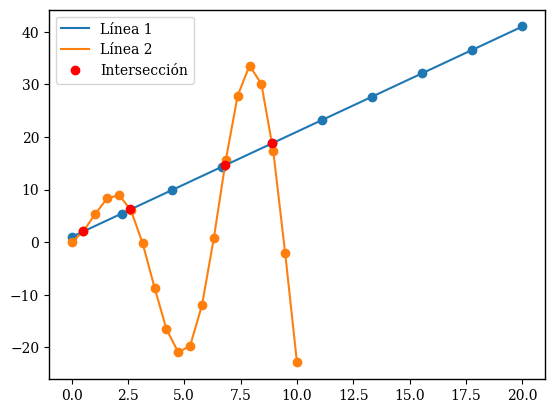

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

plt.rcParams.update({'font.size': 10})  # Set the font size

def find_intersection(line1, line2):
    intersection_points = []
    for i in range(len(line1) - 1):
        for j in range(len(line2) - 1):
            path1 = Path([line1[i], line1[i+1]])
            path2 = Path([line2[j], line2[j+1]])
            if path1.intersects_path(path2):
                x_int, y_int = get_intersection(line1[i], line1[i+1], line2[j], line2[j+1])
                intersection_points.append((x_int, y_int))
    return intersection_points

def get_intersection(p1, p2, p3, p4):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denom == 0:
        return None, None
    x_int = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
    y_int = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom
    return x_int, y_int

# Datos de ejemplo
x1 = np.linspace(0, 20, 10)
y1 = 2 * x1 + 1

x2 = np.linspace(0, 10, 20)
y2 = (4 * x2 + 2)*np.sin(x2)

# Encontrar la intersección entre las líneas
intersection_points = find_intersection(np.column_stack((x1, y1)), np.column_stack((x2, y2)))

# Plot de las líneas
plt.plot(x1, y1, label='Línea 1')
plt.plot(x2, y2, label='Línea 2')
plt.scatter(x1, y1)
plt.scatter(x2, y2)

# Plot de los puntos de intersección
if intersection_points:
    intersection_points = np.array(intersection_points)
    plt.plot(intersection_points[:, 0], intersection_points[:, 1], 'ro', label='Intersección')

print(intersection_points)
    

plt.legend()
plt.show()

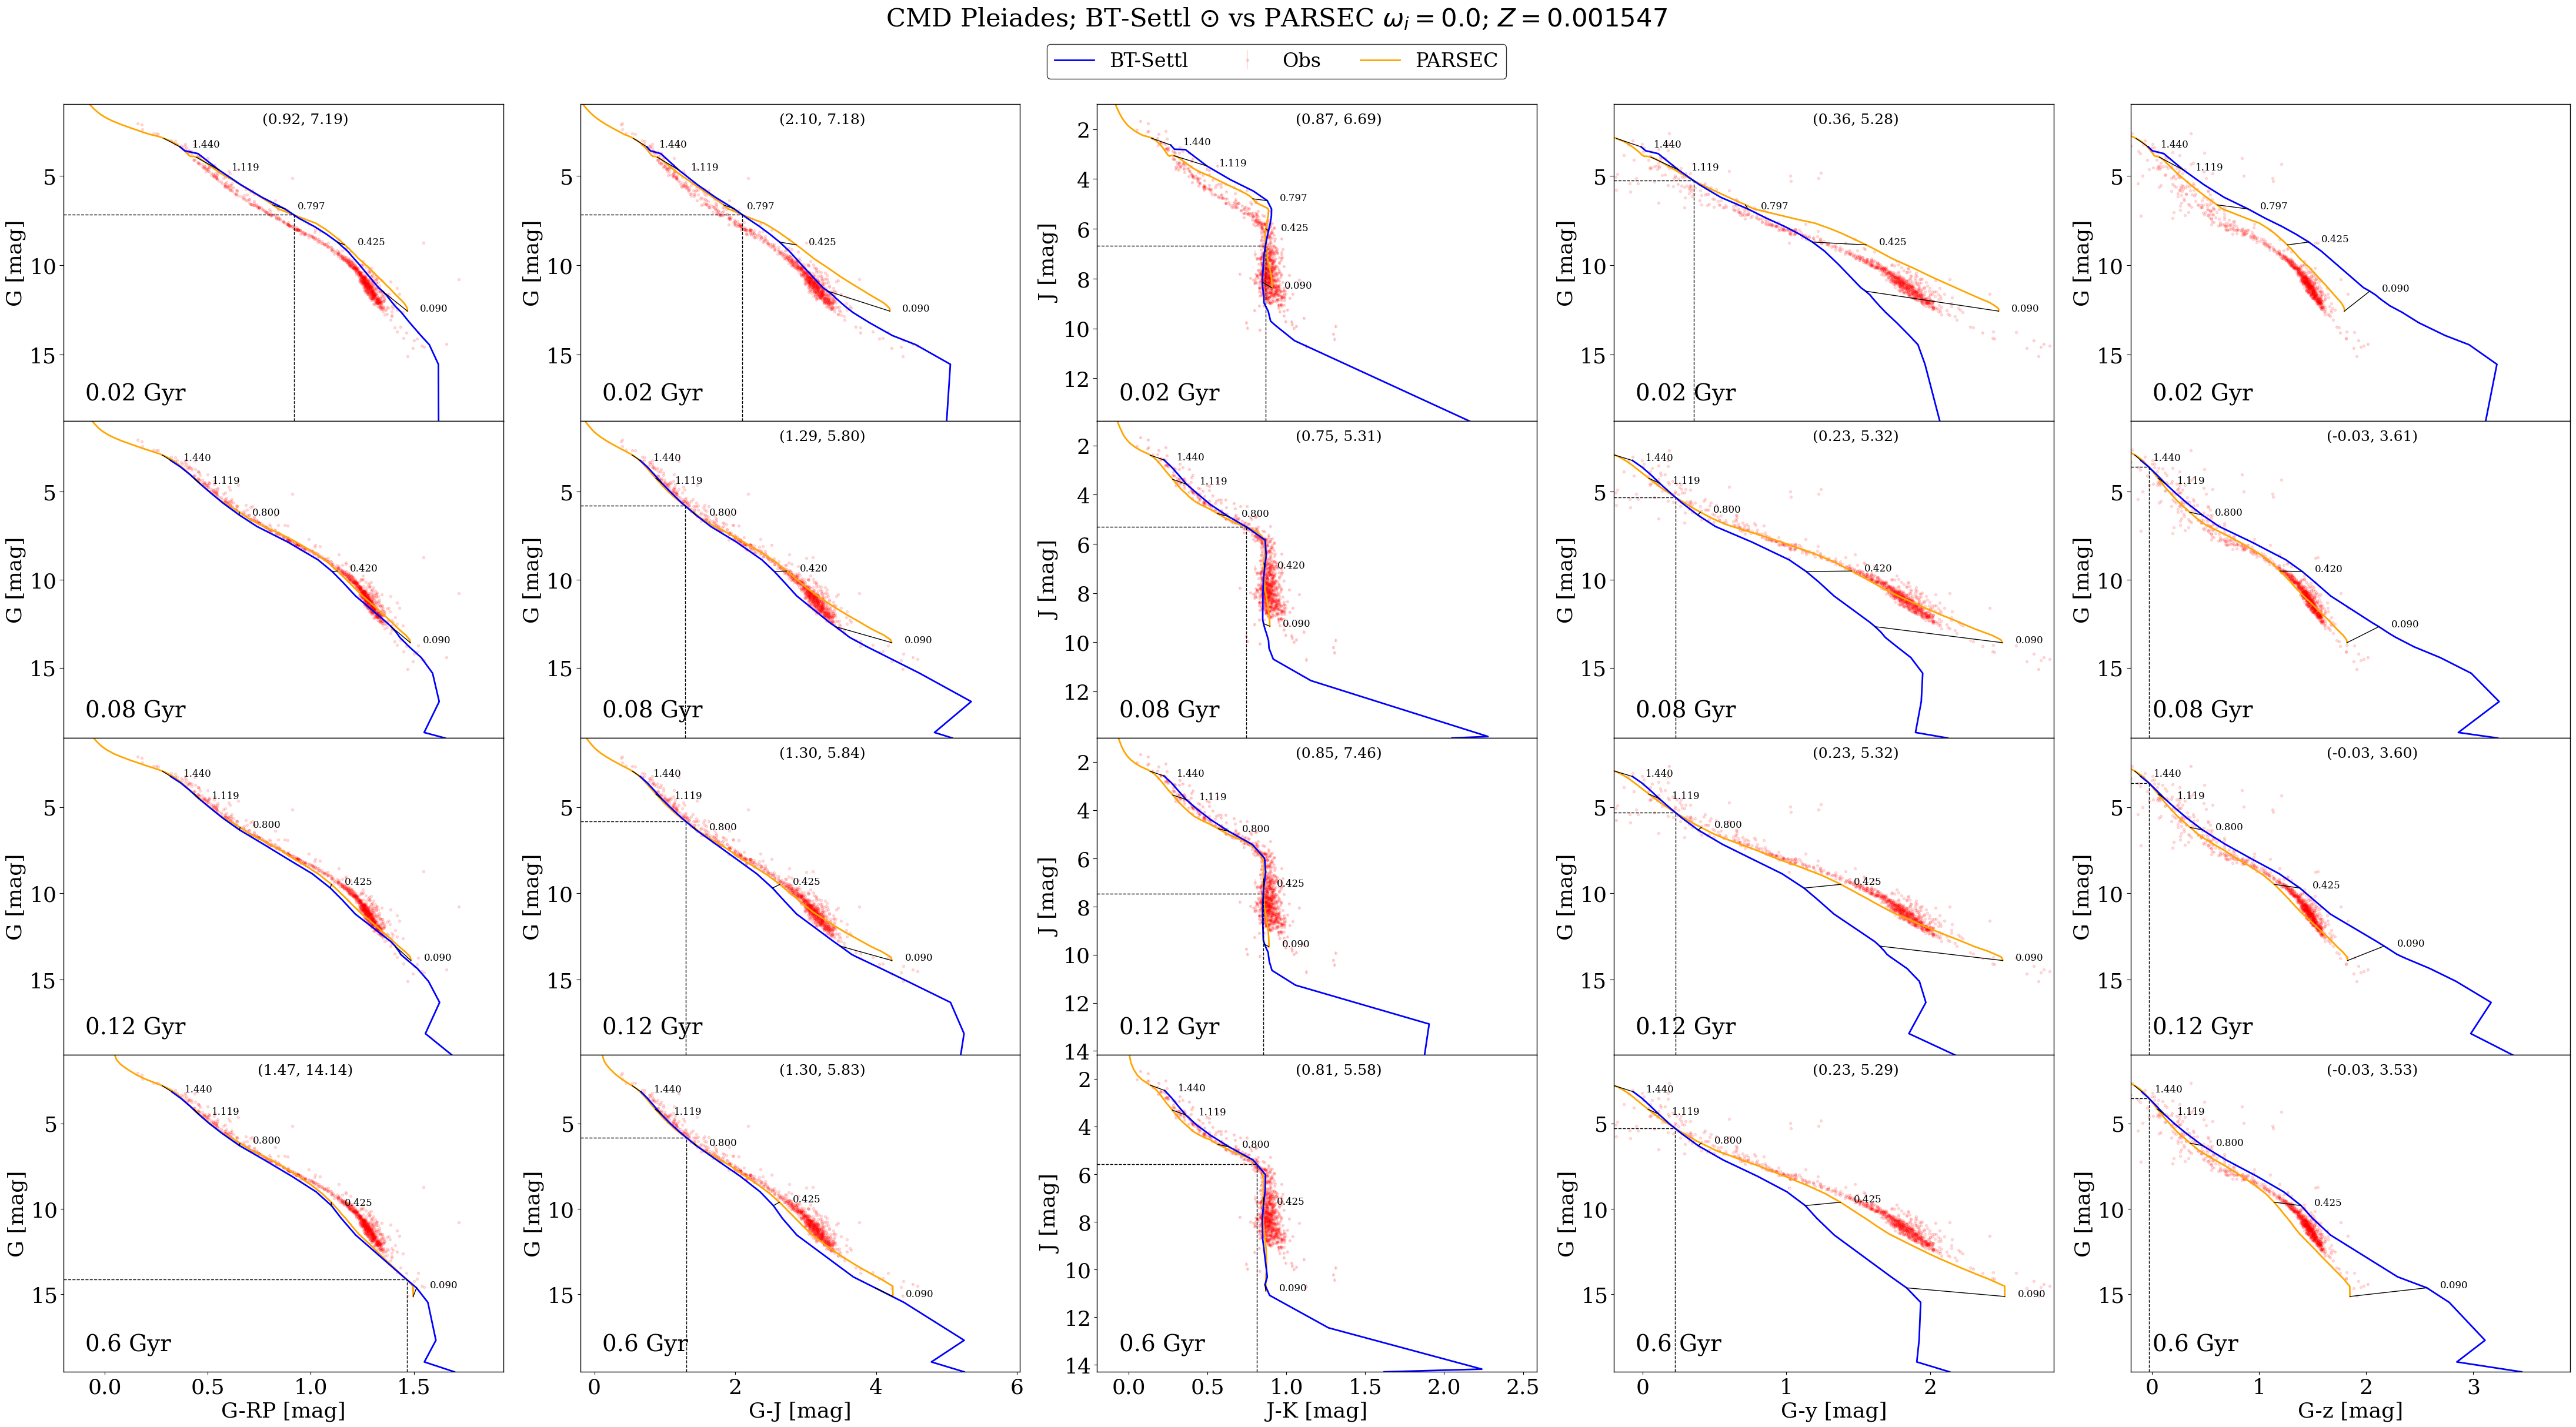

In [47]:
bands1 = [['G', 'RP'], ['G', 'J'], ['J', 'K'], ['G', 'y'], ['G', 'z']]
bands2 = [['G_i00', 'G_RP_i00'], ['G_i00', 'J_i00'], ['J_i00', 'Ks_i00'], ['G_i00', 'yP1_i00'], ['G_i00', 'zP1_i00']]
bandsobs = [['g', 'rp'], ['g', 'Jmag'], ['Jmag', 'Kmag'], ['g', 'ymag'], ['g', 'zmag']]


# Function to get the first word of a string
def get_first_word(string):
    return string.split()[0]

# Function to save the model comparison
def save_model_comparison(filename, mod1, mod2, dpi=400):
    mod1_first_word = get_first_word(mod1)
    mod2_first_word = get_first_word(mod2)
    final_filename = f"{filename}_{mod1_first_word}_{mod2_first_word}.png"
    plt.savefig(final_filename, dpi=dpi, bbox_inches='tight')

# Function to find intersection between two lines
def find_intersection(line1, line2):
    intersection_points = []
    for i in range(len(line1) - 1):
        for j in range(len(line2) - 1):
            path1 = Path([line1[i], line1[i+1]])
            path2 = Path([line2[j], line2[j+1]])
            if path1.intersects_path(path2):
                x_int, y_int = get_intersection(line1[i], line1[i+1], line2[j], line2[j+1])
                intersection_points.append((x_int, y_int))
    return intersection_points

# Function to find the intersection point between two line segments
def get_intersection(p1, p2, p3, p4):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denom == 0:
        return None, None
    x_int = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
    y_int = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom
    return x_int, y_int    

# Definition of bands
bands1 = [['G', 'RP'], ['G', 'J'], ['J', 'K'], ['G', 'y'], ['G', 'z']]
bands2 = [['G_i00', 'G_RP_i00'], ['G_i00', 'J_i00'], ['J_i00', 'Ks_i00'], ['G_i00', 'yP1_i00'], ['G_i00', 'zP1_i00']]
bandsobs = [['g', 'rp'], ['g', 'Jmag'], ['Jmag', 'Kmag'], ['g', 'ymag'], ['g', 'zmag']]

# Main function to plot the isochrones grid
def plot_isochrones_grid(model1_dict, model2_dict, bands1, bands2, mod1, mod2, filename=None, dpi=350, data_obs=None, obs=False):
    plt.rcParams.update({'font.size': 26})  # Set the font size

    fig, axs = plt.subplots(4, 5, figsize=(55, 28), sharex='col')  # Create the figure and subplots
    isochrones = [0.02, 0.08, 0.12, 0.6]  # List of isochrones to use
    max_mass_labels = 5  # Maximum number of mass labels to show
    
    legend_labels = {f'{get_first_word(mod1)}': f'{get_first_word(mod1)}',
                     f'{get_first_word(mod2)}': f'{get_first_word(mod2)}',
                     'Obs': 'Obs'}
    
    # Iterate over each column (band combination)
    for i, (band1, band2) in enumerate(zip(bands1, bands2)):
        max_x_column = float('-inf')
        max_y = float('-inf')

        # Iterate over each row (isochrone)
        for j, isochrone in enumerate(isochrones):
            ax = axs[j, i]
            isochrone_1 = min(model1_dict.keys(), key=lambda x: abs(x - isochrone))
            isochrone_2 = min(model2_dict.keys(), key=lambda x: abs(x - isochrone))

            model1_df = model1_dict[isochrone_1]
            model1_df = model1_df.loc[model1_df['M/Ms'] < 1.5]
            model1_df = model1_df.loc[model1_df['M/Ms'] > 0.08]
            
            model2_df = model2_dict[isochrone_2]
            model2_df = model2_df.loc[model2_df['M/Ms'] < 1.5]
            model2_df = model2_df.loc[model2_df['M/Ms'] > 0.08]
            
            min_mm_model1 = min(model1_df['M/Ms'])
            min_mm_model2 = min(model2_df['M/Ms'])

            mm_values = np.linspace(1.5, min(min_mm_model1, min_mm_model2), 5)

            x1 = model1_dict[isochrone_1][band1[0]] - model1_dict[isochrone_1][band1[1]]
            y1 = model1_dict[isochrone_1][band1[0]]
            x2 = model2_dict[isochrone_2][band2[0]] - model2_dict[isochrone_2][band2[1]]
            y2 = model2_dict[isochrone_2][band2[0]]

            ax.plot(x1, y1, label=f'{get_first_word(mod1)}', zorder=2, linewidth=2, color='blue')
            ax.plot(x2, y2, label=f'{get_first_word(mod2)}', zorder=1, linewidth=2, color='orange')

            max_x_column = max(max_x_column, np.max(x1), np.max(x2))
            max_y = max(max_y, np.max(y1), np.max(y2))
            
            for mm_value in mm_values:
                closest_row_model1 = model1_df.iloc[(model1_df['M/Ms'] - mm_value).abs().argsort()[:1]]
                closest_row_model2 = model2_df.iloc[(model2_df['M/Ms'] - mm_value).abs().argsort()[:1]]

                x_mass_model1 = closest_row_model1[band1[0]] - closest_row_model1[band1[1]]
                y_mass_model1 = closest_row_model1[band1[0]]
                mass_model1 = closest_row_model1['M/Ms']

                x_mass_model2 = closest_row_model2[band2[0]] - closest_row_model2[band2[1]]
                y_mass_model2 = closest_row_model2[band2[0]]
                mass_model2 = closest_row_model2['M/Ms']

                for x_mass1, y_mass1, mass1, x_mass2, y_mass2, mass2 in zip(x_mass_model1, y_mass_model1, mass_model1, x_mass_model2, y_mass_model2, mass_model2):
                    text = f'{((mass1+mass2)/2):.3f}'
                    text_length = len(text) * 0.15  # Estimar la longitud del texto (suponiendo 0.15 como el ancho aproximado por carácter)
                    text_height = 0.03  # Estimar la altura del texto (suponiendo 0.03)

                    if x_mass2 - x_mass1 < 0:
                        text_x = x_mass1 + (1/30)*(max_x_column+0.2)
                        ax.text(text_x, y_mass1, text, fontsize=12, color='k')
                    elif x_mass1 - x_mass2 < 0:
                        text_x = x_mass2 + (1/30)*(max_x_column+0.2)
                        ax.text(text_x, y_mass2, text, fontsize=12, color='k')

                    ax.plot([x_mass1, x_mass2], [y_mass1, y_mass2], color='k', linewidth=1)

            intersection_points = find_intersection(np.column_stack((x1, y1)), np.column_stack((x2, y2)))

            if intersection_points:
                first_point = intersection_points[-1]
                if -0.2 <= first_point[0] <= max_x_column and 1 <= first_point[1] <= max_y:
                    ax.plot([-0.2, first_point[0]], [first_point[1], first_point[1]], color='black', linewidth=1, linestyle='--')
                    ax.plot([first_point[0], first_point[0]], [max_y, first_point[1]], color='black', linewidth=1, linestyle='--')
                    ax.text(0.55, 0.95, f'({first_point[0]:.2f}, {first_point[1]:.2f})', fontsize=18, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='black')  # Adjusted position for text
                else:
                    pass
            
            # Plot observational data if available
            if obs:
                ax.errorbar(data_obs[f'{bandsobs[i][0]}'+'_abs']-data_obs[f'{bandsobs[i][1]}'+'_abs'],
                            data_obs[f'{bandsobs[i][0]}'+'_abs'], 
                            yerr=data_obs['e_'+f'{bandsobs[i][0]}'], fmt='.', alpha=0.125, label='Obs', zorder=0, color='r')

            if j == 3:
                ax.set_xlabel(f'{band1[0]}-{band1[1]} [mag]')
                ax.set_ylabel(f'{band1[0]} [mag]')
                ax.xaxis.set_major_locator(ticker.AutoLocator())
                ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
                ax.text(0.05, 0.05, f'{isochrone_1} Gyr', transform=ax.transAxes, fontsize=28, verticalalignment='bottom', horizontalalignment='left')  # Adjusted position for text

            else:
                ax.set_ylabel(f'{band1[0]} [mag]')
                ax.set_xticklabels([])
                ax.tick_params(axis='both', which='both', length=5)

                ax.text(0.05, 0.05, f'{isochrone_1} Gyr', transform=ax.transAxes, fontsize=28, verticalalignment='bottom', horizontalalignment='left')  # Adjusted position for text

            ax.set_xlim(-0.2, max_x_column+(1/8)*(max_x_column+0.2))
            ax.set_ylim(1, max_y)
            ax.invert_yaxis()

    plt.subplots_adjust(hspace=0, wspace=0.175)
    fig.suptitle(f'CMD Pleiades; {mod1} vs {mod2}', y=0.94)
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = list(set(labels))
    legend_handles = [handles[labels.index(label)] for label in unique_labels]
    fig.legend(legend_handles, unique_labels, loc='upper center', bbox_to_anchor=(0.5, 0.9225), fontsize=24, ncol=3, edgecolor='black')  # Añadir leyenda debajo del título
    if filename:
        save_model_comparison(filename, mod1, mod2, dpi=dpi)
    plt.show()


# Example usage
plot_isochrones_grid(BTSettl_Li_isochrones, PARSEC_iso_omega_00_Phot_dict, bands1, bands2, 'BT-Settl $\odot$', r'PARSEC $\omega_i=0.0$; $Z=0.001547$', filename='model_comparison', data_obs=data_obs_Pleiades, obs=True)

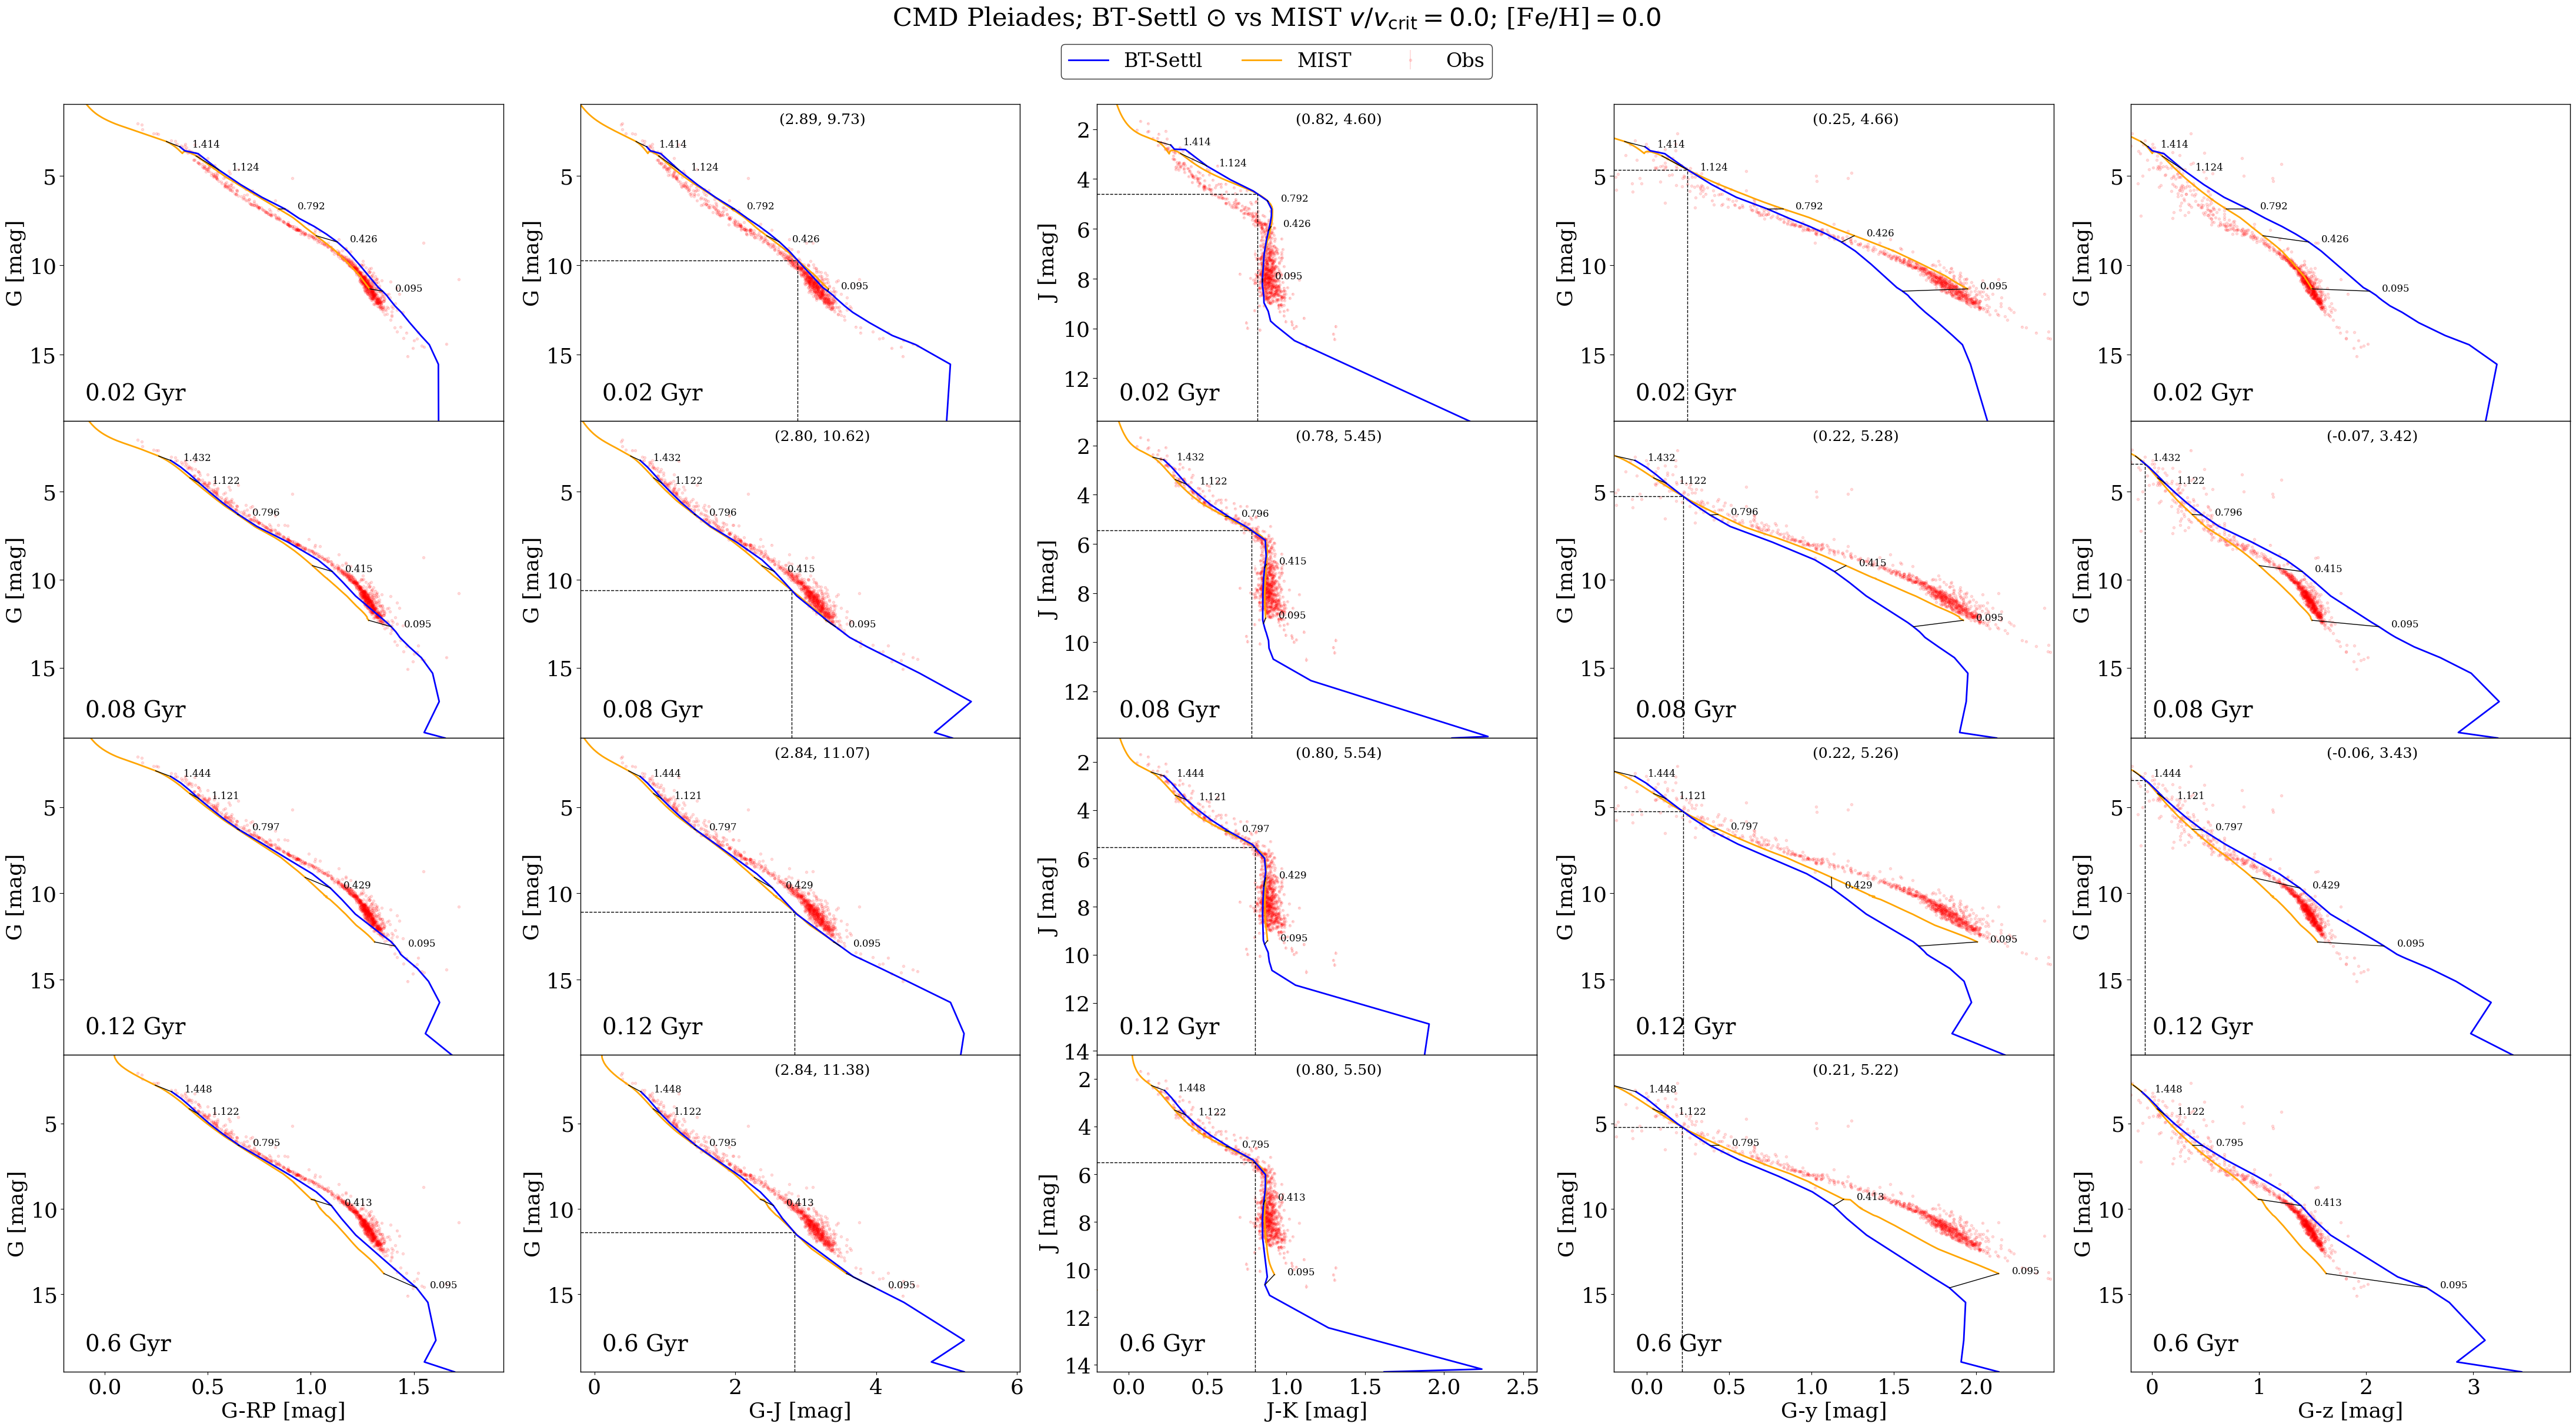

In [48]:
plot_isochrones_grid(BTSettl_Li_isochrones, MIST_00_00, bands1, bands1, 'BT-Settl $\odot$', r'MIST $v/v_{\rm crit}=0.0$; [Fe/H]$=0.0$', filename='model_comparison', data_obs=data_obs_Pleiades, obs=True)


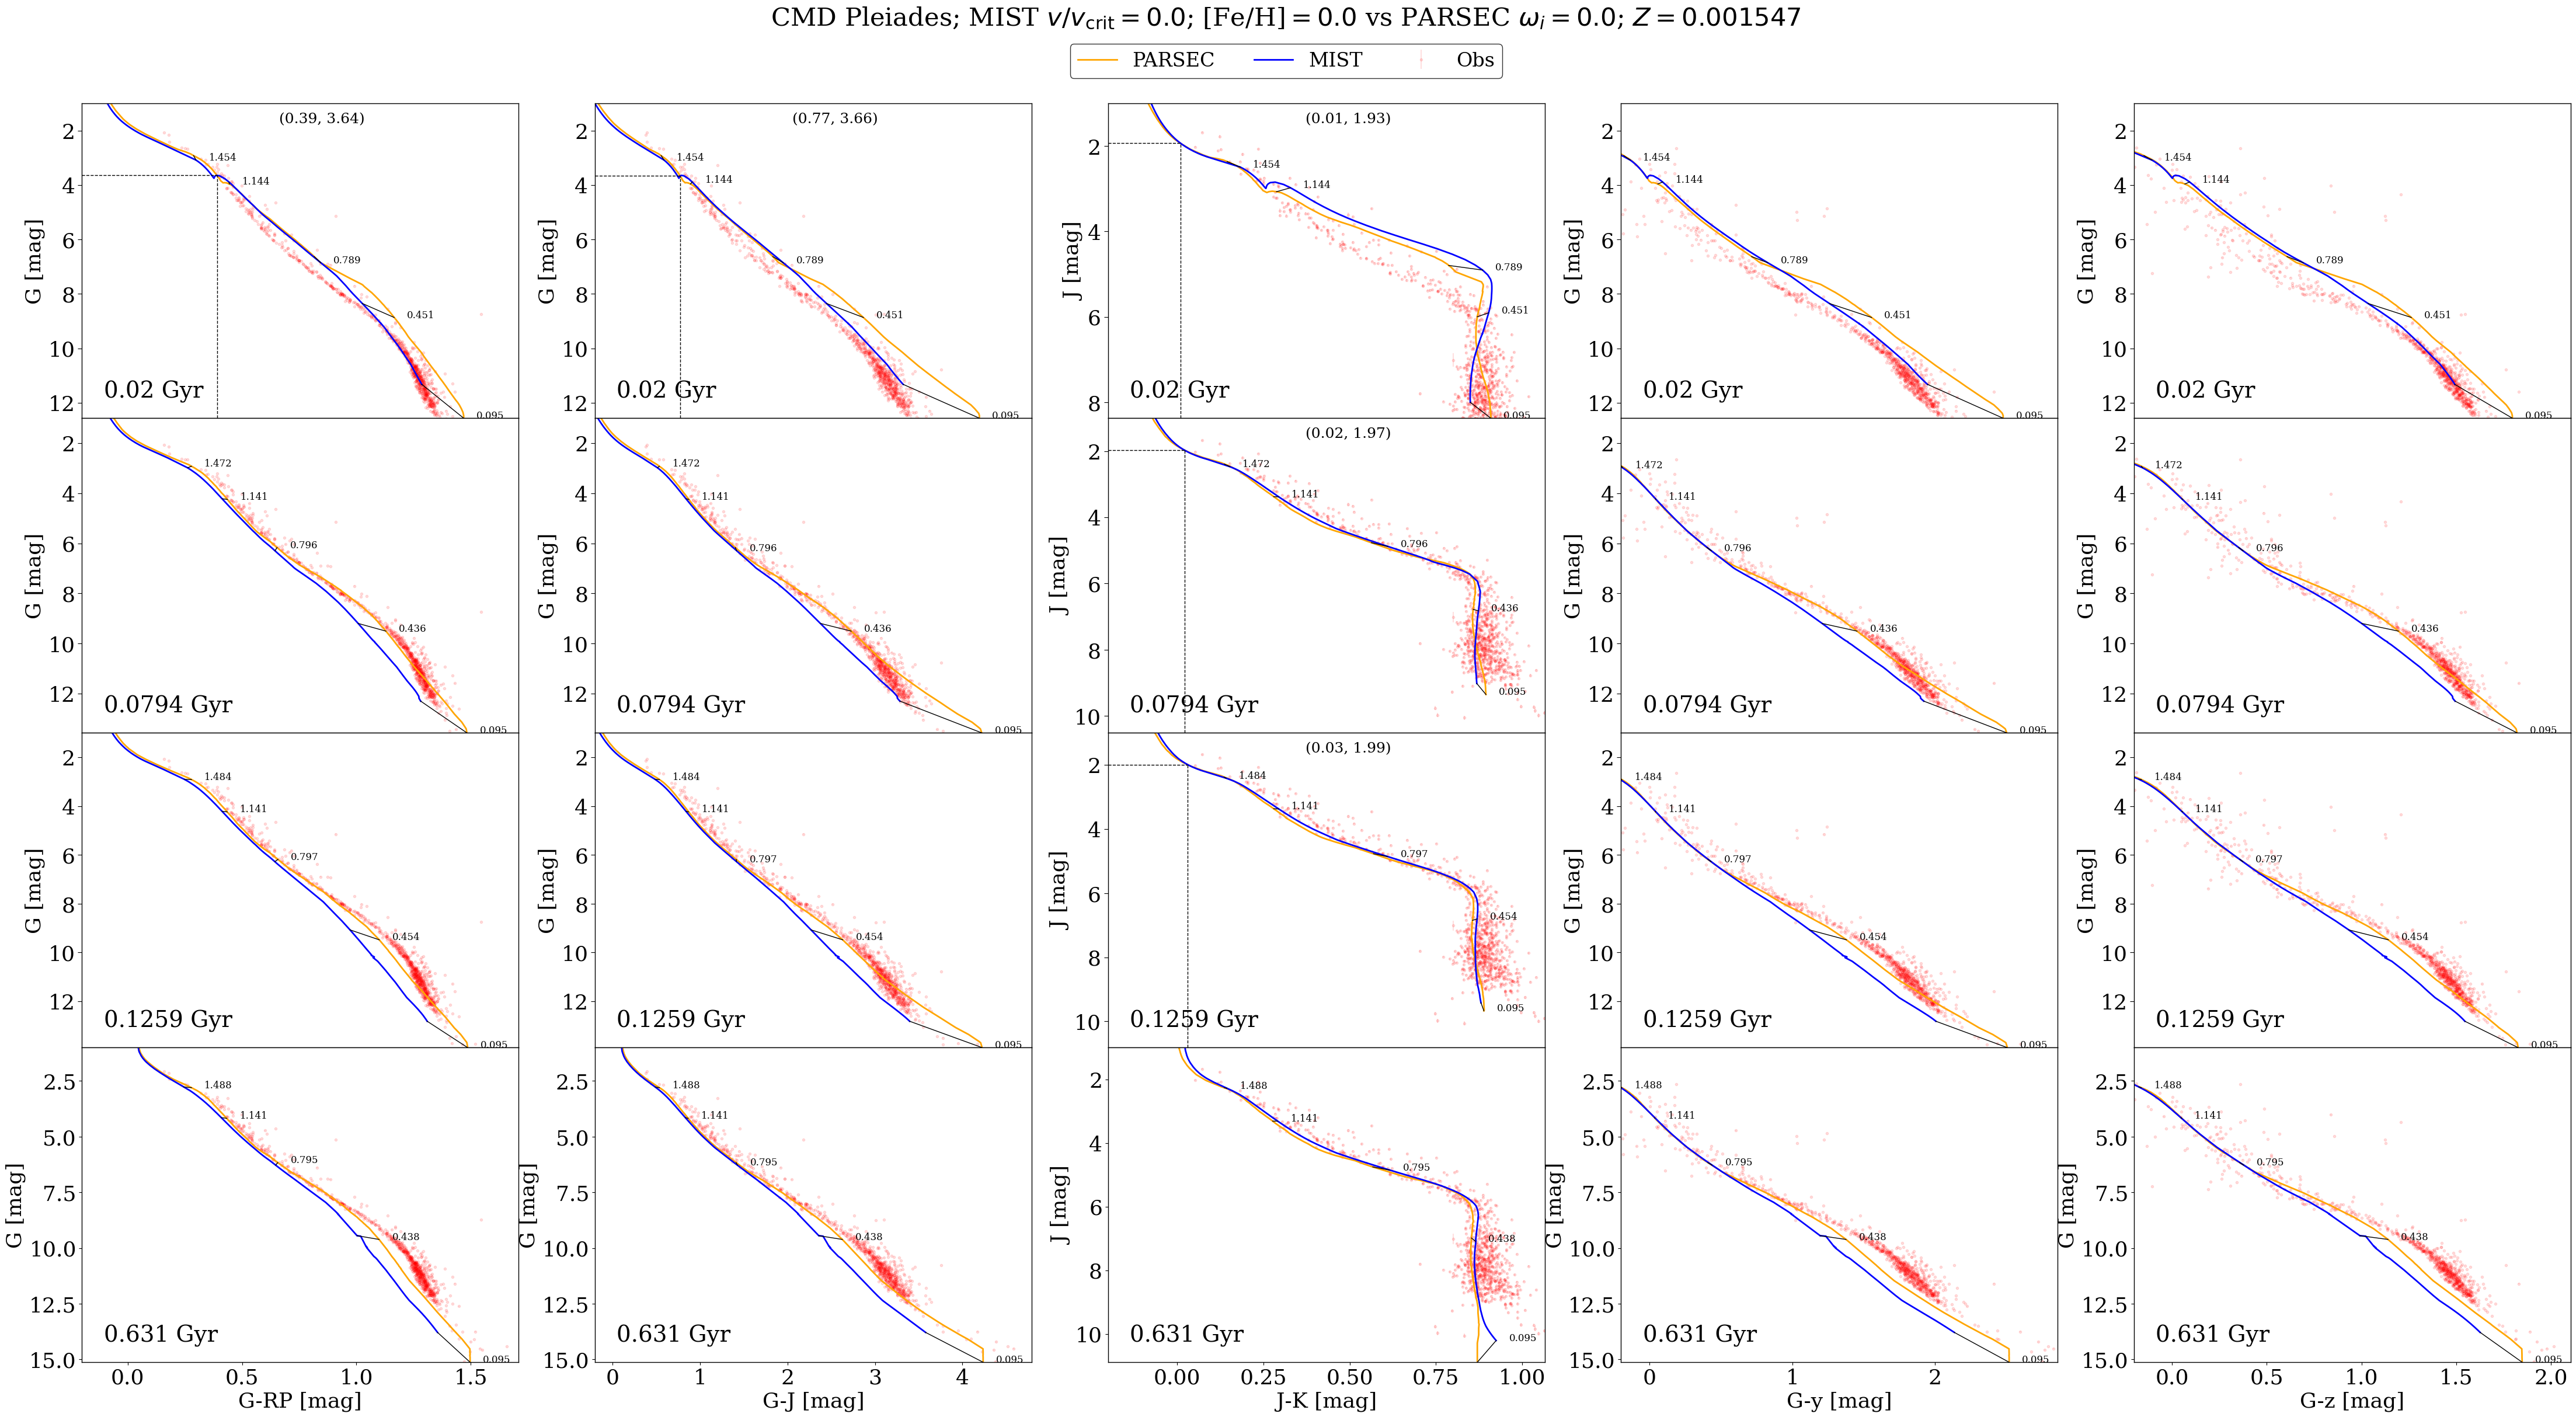

In [49]:
plot_isochrones_grid(MIST_00_00, PARSEC_iso_omega_00_Phot_dict, bands1, bands2, r'MIST $v/v_{\rm crit}=0.0$; [Fe/H]$=0.0$', r'PARSEC $\omega_i=0.0$; $Z=0.001547$', filename='model_comparison', data_obs=data_obs_Pleiades, obs=True)


In [50]:
(1e7*(0.3)**(-2.5))/1e9

0.20286020648339487